원문은 여기 있습니다. [Original Post]('https://sebastianraschka.com/Articles/2014_multiprocessing.html#sections')

# 파이썬의 멀티프로세싱 모듈을 활용한 병렬 프로그래밍 입문
2014년 6월 20일 Sebastian Raschka

멀티코어를 지닌 CPU는 이제 현대 컴퓨터 설계에서 표준이 되었고 이제는 슈퍼컴퓨터와 같은 시설 이외에도 집에 있는 데스크탑이나 노트북, 심지어 애플의 아이폰 5s 프로세서 1.3Ghz 듀얼 코어에서도 찾을 수 있다.

하지만, 기본 파이썬 인터프리터는 간결성을 중점으로 설계되었고 쓰레드-세이프 메커니즘을 갖고 있다. 소위 "GIL"(Global Interpreter Lock)이 그것이다. 쓰레드간의 충돌을 방지하기 위해서, 오직 한 선언(statement)을 한번씩만 실행시킨다. (이를 Serial 프로세싱, 혹은 싱글-쓰레딩 이라 한다.)

해당 파이썬 멀티프로세싱 소개글에서는, 어떻게 여러개의 서브프로세스를 만들고 GIL의 불리한 점을 피할 수 있을지 알아본다.

- 목차
- 멀티 쓰레딩 vs. 멀티 프로세싱
- 멀티프로세싱 모듈 소개
    - Process 클래스
    - 특정 순서로 결과를 추출하는 방법
    - Pool 클래스
- 벤치마크 함수로서의 커널 밀도 추정
    - 파젠 윈도우 방법 요약
    - 샘플 데이터와 timeit 벤치마크
    - 벤치마크 함수
    - 결과 시각화 준비하기
- 결과
- 결론

## 멀티 쓰레딩 vs. 멀티 프로세싱

어플리케이션에 따라 다르겠지만, 병렬 프로그래밍에서의 흔한 두 가지 방법은 코드를 쓰레드를 통해 실행시키거나 여러개의 프로세스들을 통해 실행시키는 것이다. 우리가 "jobs"들을 각각 쓰레들들에게 제출하면, 이 "jobs"들은 싱글 쓰레드의 "sub-tasks" 들로 간주되고 각 쓰레드들은 같은 메모리에 접속할 권한을 갖게 된다.(공유 메모리). 이 접근법은 부적절한 동기화가 일어날 경우 쉽게 충돌이 일어나는데, 예를 들어 프로세스들이 같은 메모리 자리에 같은 시간에 쓰기를 하는 경우에 이러한 충돌이 발생할수 있다.

보다 안전한 접근법은 (비록 오버헤드가 분리된 프로세스간의 커뮤니케이션 비용 때문에 발생하지만), 여러개의 프로세스들을 완전히 분리된 메모리 위치들로 (분산된 메모리) 보내는 것이다. 모든 프로세스들은 완전히 스스로 독립되어서 동작하는 것이다.

여기서는, 파이썬의 [멀티프로세싱](https://docs.python.org/dev/library/multiprocessing.html) 모듈을 보고  독립적으로 실행할 수 있는 프로세스들을 제출하여 CPU 코어를 최대한 활용할 수 있는 방법에 관해 알아보도록 하겠습니다.

## 멀티프로세싱 모듈 소개

파이썬의 표준 라이브러리인 [멀티프로세싱](https://docs.python.org/dev/library/multiprocessing.html)은 다양한 강력한 기능들이 있다. 여기에 대해 자세히 알고 싶다면 [공식 문서](https://docs.python.org/dev/library/multiprocessing.html)를 추천한다. 

여기에서는, 멀티프로세싱 모듈이 병렬 프로그래밍에서 어떻게 사용되는지에 관한 다양한 접근방법들을 요약해서 제공할 것이다.

### Process 클래스

여기서 가장 간단한 접근법은 아마 Process 클래스를 multiprocessing 모듈에서 사용하는 것이다.

In [1]:
import multiprocessing as mp
import random
import string

random.seed(123)

# Define an output queue
output = mp.Queue()

def rand_string(length, output):
    """ Generates a random string of numbers, lower- and uppercase chars. """
    rand_str = ''.join(random.choice(
                          string.ascii_lowercase
                        + string.ascii_uppercase
                        + string.digits)
                   for i in range(length))
    output.put(rand_str)
    
# Setup a list of processes that we want to run
processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)]

# Run processes
for p in processes:
    p.start()
    
# Exit the completed processes
for p in processes:
    p.join()

    
results = [output.get() for p in processes]

print (results)

['Q8iWd', 'WyfPV', '6KWAd', 'bIxLT']


### 특정 순서로 결과를 추출하는 방법

획득한 결과의 순서는 프로세스 목록 안의 프로세스 순서들과 반드시 일치하진 않는다. 우리는 여기서 .get() 메서드를 사용하여 정보를 Queue에서 순차적으로 추출했기 때문에, 프로세스가 종료된 순서가 결과의 순서를 결정한다. 예를 들어, 두번째 프로세스가 첫번째 프로세스보다 먼저 끝났더라면, ['7SVNF', 'tg21e', 'BSPdJ', 'JS1C2'] 대신 ['tg21e', '7SVNF', 'BSPdJ', 'JS1C2'] 가 되었을 것이다.

만약 우리의 어플리케이션이 정보를 특정한 순서로 추추할 것을 요구한다면, 우리는 프로세스의 .\_identity 속성을 참고할 수 있다. 이 경우 우리는 그저 range 객체에서의 값을 위치를 argument로 사용하면 된다. 수정된 코드는 다음과 같다.

In [2]:
# Define an output queue
output = mp.Queue()

# define a example function
def rand_string(length, pos, output):
    """ Generates a random string of numbers, lower- and uppercase chars. """
    rand_str = ''.join(random.choice(
                          string.ascii_lowercase
                        + string.ascii_uppercase
                        + string.digits)
                   for i in range(length))
    output.put((pos, rand_str))

# Setup a list of processes that we want to run
processes = [mp.Process(target=rand_string, args=(5, x, output)) for x in range(4)]

# Run processes
for p in processes:
    p.start()

# Exit the completed processes
for p in processes:
    p.join()

# Get process results from the output queue
results = [output.get() for p in processes]

print(results)

[(0, 'onrFk'), (1, '7lEgQ'), (2, 'xC6gZ'), (3, 'sG44l')]


추출된 결과는 튜플이 될 것이다.

In [3]:
results.sort()
results = [r[1] for r in results]
print (results)

['onrFk', '7lEgQ', 'xC6gZ', 'sG44l']


In [4]:
results

['onrFk', '7lEgQ', 'xC6gZ', 'sG44l']

**정렬 된 결과를 유지하는 더 간단한 방법은, 다음 섹션에서 논의 할 Pool.apply 및 Pool.map 함수를 사용하는 것이다. **

### Pool 클래스

간단한 병럴 작업들에 접근하는 더 간편한 방법은 Pool 클래스에서 제공된다.

여기서 특히나 중요한 메서드들로는
- pool.apply
- pool.map
- pool.apply_async
- pool.map_async

pool.apply, pool.map 메서드들은 기본적으로 파이썬의 내장 apply와 map 함수와 동일하다. 

pool 메서드의 변형들인 async(비동기)에 대해 알아보기 전에, pool.apply와 pool.map 의 간단한 예를 살펴보자. 여기서 프로세스의 개수를 4개로 설정한다. 이는 pool 클래스는 오직 4개까지 동시에 동작하도록 설정하는 것이다.

In [5]:
def cube(x):
    return x**3

In [6]:
pool = mp.Pool(processes=4)
results = [pool.apply(cube, args=(x,)) for x in range(1,7)]
print(results)

[1, 8, 27, 64, 125, 216]


In [7]:
pool = mp.Pool(processes=4)
results = pool.map(cube, range(1,7))
print(results)

[1, 8, 27, 64, 125, 216]


Pool.map과 Pool.apply는 모든 프로세스가 완료 될때까지 메인 프로그램을 잠그기 때문에(lock), 특정 어플리케이션에 대해 특정 순서로 결과를 얻기에 매우 유용하다.

반대로, async(비동기) 변형들은 모든 프로세스를 한번에 제출하고, 이것이 완료된 직후 결과를 추출한다. 추가로, apply\_asynce() 를 호출한 경우 완료 값들을 반환받기 위해서는 get 메소드를 사용하여야 한다.

In [8]:
pool = mp.Pool(processes=4)
results = [pool.apply_async(cube, args=(x,)) for x in range(1,7)]
output = [p.get() for p in results]
print(output)


[1, 8, 27, 64, 125, 216]


# 벤치마킹 함수로서의 커널 밀도 추정

이번에는 간단한 순차적 vs 멀티프로세싱 접근법의 비교를 진행하겠다. 아까의 cube 예제보다는 좀더 복잡한 함수를 사용할 것이다.

여기서 파젠-윈도우 (Parzen-window) 기술을 사용하여, 확률 밀도 함수를 위한 커널 밀도 추정을 수행하는 함수를 정의한다. [파젠-윈도우](https://sebastianraschka.com/Articles/2014_kernel_density_est.html)에 관한 자세한 내용은 링크를 참고하시오.

In [9]:
import numpy as np

def parzen_estimation(x_samples, point_x, h):
    """
    Implementation of a hypercube kernel for Parzen-window estimation.

    Keyword arguments:
        x_sample:training sample, 'd x 1'-dimensional numpy array
        x: point x for density estimation, 'd x 1'-dimensional numpy array
        h: window width

    Returns the predicted pdf as float.

    """
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
            
    return (k_n / len(x_samples)) / (h**point_x.shape[1])

** "Completion else" 에 관한 간단한 노트 **

여기에 else를 의도적으로 붙였는지, 실수로 붙였는지에 관해 질문을 받는 경우가 있다. 좋은 질문이다. "completion-else"는 잘 사용되는 문법이 아니기 때문에(나는 이를 이렇게 부르는데, "공식" 명명법이 있다면 알려 주세요.)
이에 관해 자세한 설명은 내 블로그 [포스트]('http://sebastianraschka.com/Articles/2014_deep_python.html#else_clauses')를 참고하세요. 결론을 요약하자면, if-else와 달리 "completion else"는 만약 이전의 코드가 온전히 끝난 후에야만 실행된다.

### 파젠 윈도우 방법 요약

이 함수가 무엇을 하는지 간단해 말해 보면: 정해진 지역의 포인트들을 세고(윈도우라 부른다), 이 포인트들을 전체 포인트 개수만큼 나누어서 특정 지역에서 하나의 단일점이 가지는 확률을 추정한다.

아래는 윈도우가 원점에 중심을 둔 하이퍼 큐브로 표현된 간단한 예제이며, 하이퍼 큐브 기반에 있는 지점의 중심에 있는 점의 확률을 얻는 것을 목표로 한다.

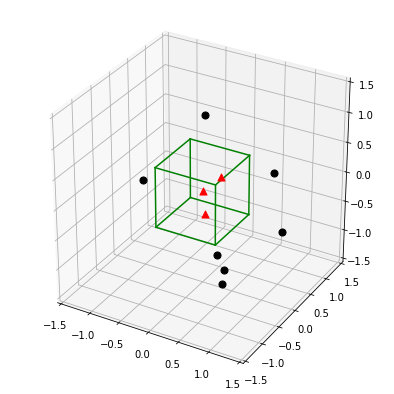

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

# Plot Points

# samples within the cube
X_inside = np.array([[0,0,0],[0.2,0.2,0.2],[0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                      [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                      [0.7,-0.6,-0.8]])

for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')

for row in X_outside:    
    ax.scatter(row[0], row[1], row[2], color="k", s=50)

# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()

In [12]:
point_x = np.array([[0],[0],[0]])
X_all = np.vstack((X_inside,X_outside))

print('p(x) =', parzen_estimation(X_all, point_x, h=1))

p(x) = 0.3


### 샘플 데이터와 timeit 벤치마크

아래에서는 원점을 중심으로 한 평균 벡터와 항등 행렬을 공분산 행렬하는 이변량 가우스 분포로부터 임의의 데이터 세트를 생성한다.

In [15]:
import numpy as np

np.random.seed(123)

# Generate random 2D-patterns
mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)

분포의 중심에있는 점의 추정 확률은 ~ 0.15915이다. 우리의 목표는 파젠-윈도우 접근법을 이용하여 우리가 만든 샘플 데이터 셋에 기반한 밀도를 예측하는 것이다.

파젠-윈도우 기술을 통해 "좋은" 예측을하기 위해서는, 적절한 윈도우를 선택하는 것이 중요하다. 다른 윈도우의 너비들을 적용하고 멀티 프로세스들을 사용하여 이변량 가우스 분포 중심의 밀도를 예측할 것이다. 

In [17]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
print('actual probability density:', var.pdf([0,0]))

actual probability density: 0.15915494309189535


### 벤치마크 함수

순차적 및 멀티프로세싱 방법을 윟나 벤치마크 함수를 설정하여 timeit 벤치마크에 전달할 것이다.
Pool.apply_async 함수를 사용하여 프로세스들을 동시에 실행하는 이점을 지닐 것이다. 여기서는 어떤 순서로 각기 다른 창 너비에서 결과가 계산되는지는 고려하지 않는다. 단지 각각의 결과와 입력한 윈도우 너비를 연관짓는다. 따라서, 우리는 파젠-밀도-추정 함수를 튜플로 변형시킨다. 윈도우의 넓이와 추정된 밀도를 사용한다. 이는 차후에 결과를 정렬할 수 있게 해 준다.

In [18]:
def parzen_estimation(x_samples, point_x, h):
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
    return (h, (k_n / len(x_samples)) / (h**point_x.shape[1]))

In [19]:
def serial(samples, x, widths):
    return [parzen_estimation(samples, x, w) for w in widths]

def multiprocess(processes, samples, x, widths):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(parzen_estimation, args=(samples, x, w)) for w in widths]
    results = [p.get() for p in results]
    results.sort() # to sort the results by input window width
    return results

결과가 어떻게 보이는지만 알면 된다(각기 다른 윈도우 너비에 관해 예측된 밀도):

In [20]:
widths = np.arange(0.1, 1.3, 0.1)
point_x = np.array([[0],[0]])
results = []

results = multiprocess(4, x_2Dgauss, point_x, widths)

for r in results:
    print('h = %s, p(x) = %s' %(r[0], r[1]))

h = 0.1, p(x) = 0.016
h = 0.2, p(x) = 0.0305
h = 0.30000000000000004, p(x) = 0.04499999999999999
h = 0.4, p(x) = 0.06175
h = 0.5, p(x) = 0.078
h = 0.6, p(x) = 0.09116666666666667
h = 0.7000000000000001, p(x) = 0.106
h = 0.8, p(x) = 0.117375
h = 0.9, p(x) = 0.13266666666666668
h = 1.0, p(x) = 0.1445
h = 1.1, p(x) = 0.1570909090909091
h = 1.2000000000000002, p(x) = 0.16849999999999996


결과에 따르면, 최적의 윈도우 너비는 h=1.1 이라고 할 수 있다. 추정된 결과는 실제 결과인 0.15916와 비슷하기 때문이다. 따라서, 벤치마크에서는 1.0에서 1.2사이 같은 간격으로 떨어진 윈도우를 100개 만들어 보자.

In [22]:
widths = np.linspace(1.0, 1.2, 100)

In [23]:
import timeit

mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
n = 10000

x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, n)

benchmarks = []

benchmarks.append(timeit.Timer('serial(x_2Dgauss, point_x, widths)',
            'from __main__ import serial, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(2, x_2Dgauss, point_x, widths)',
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(3, x_2Dgauss, point_x, widths)',
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(4, x_2Dgauss, point_x, widths)',
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(6, x_2Dgauss, point_x, widths)',
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

### 결과 시각화 준비하기

In [29]:
import platform

def print_sysinfo():

    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())

    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [27]:
from matplotlib import pyplot as plt
import numpy as np

def plot_results():
    bar_labels = ['serial', '2', '3', '4', '6']

    fig = plt.figure(figsize=(10,8))

    # plot bars
    y_pos = np.arange(len(benchmarks))
    plt.yticks(y_pos, bar_labels, fontsize=16)
    bars = plt.barh(y_pos, benchmarks,
             align='center', alpha=0.4, color='g')

    # annotation and labels

    for ba,be in zip(bars, benchmarks):
        plt.text(ba.get_width() + 2, ba.get_y() + ba.get_height()/2,
                '{0:.2%}'.format(benchmarks[0]/be),
                ha='center', va='bottom', fontsize=12)

    plt.xlabel('time in seconds for n=%s' %n, fontsize=14)
    plt.ylabel('number of processes', fontsize=14)
    t = plt.title('Serial vs. Multiprocessing via Parzen-window estimation', fontsize=18)
    plt.ylim([-1,len(benchmarks)+0.5])
    plt.xlim([0,max(benchmarks)*1.1])
    plt.vlines(benchmarks[0], -1, len(benchmarks)+0.5, linestyles='dashed')
    plt.grid()

    plt.show()

## 결과

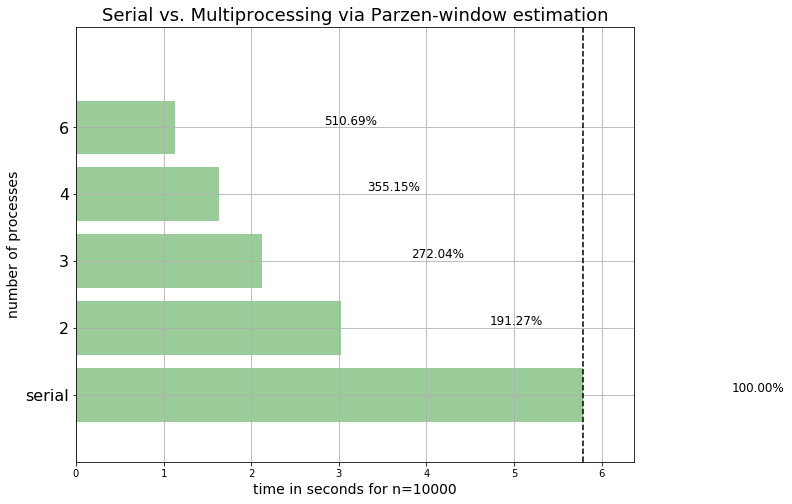


Python version  : 3.6.7
compiler        : GCC 7.3.0

system     : Linux
release    : 4.13.0-45-generic
machine    : x86_64
processor  : x86_64
CPU count  : 12
interpreter: 64bit





In [30]:
plot_results()
print_sysinfo()

# 결론

우리의 파젠-윈도우 함수를 위한 밀도 추정을 병렬로 제출할 경우 속도가 빨라지는 것을 확인했다. 만약 4코어와 6코어의 차이가 미미하다면, 이는 실제로는 4코어 컴퓨터이기 때문에 성능향상이 없는 것이다. 

코어의 수가 증가할수록 상승폭도 줄어드는 것을 확인할 수 있다.

이는 CPU의 코어수가 한정되어 있기 때문이기도 하고 시스템 프로세스들, 운영체제와 같은 것들이 백그라운드에서 돌아가고 있기 때문이다. 그렇기 때문에 마지막 코어는 성능 향상의 여력이 없는 것이다. 또한 프로세스가 추가될 때마다 프로세스간 통신을 위한 오버헤드가 발생한다.

또한, 이러한 개선은 작업들이 "CPU-바운드" 일때 발생한다. 디스크에서 데이터를 처리하는 I/O 바운드 작업들이 있을 때가 아니다.